# Ethereum Price Regression model
The aim of this notebook is to build a model that can predict the price of the cryptocurreny Ethereum, given past data (4 years of daily price data).
> How well can we predict the closing price of one Ether, given its previous closing price data?

Note that this nb is not treating the data sequentially.

<hr/>

Data can be source from Yahoo at this link: https://au.finance.yahoo.com/quote/ETH-AUD/history?period1=1541376000&period2=1604534400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true, between the periods of 18/11/2016 to 05/11/2020.

### Setup up env and look at data

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Import preprocessed data (if it exists)
df = pd.read_csv("data/processed_ETH-AUD",
                    low_memory=False)

In [15]:
price_data = pd.read_csv("./data/ETH-AUD-2016to2020.csv",
                         low_memory=False)

price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-18,13.501419,13.527241,12.809084,12.901511,12.901511,14725799
1,2016-11-19,12.910578,13.268645,12.909572,13.155561,13.155561,7061320
2,2016-11-20,13.153451,13.221361,13.009252,13.079301,13.079301,7063653
3,2016-11-21,13.080503,13.157393,12.946662,13.046948,13.046948,4967737
4,2016-11-22,13.053648,13.856814,12.990789,13.371652,13.371652,15232721


In [4]:
price_data.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [34]:
print(price_data.shape)
print()
print(price_data.dtypes)
print()
print(price_data.info());

(732, 7)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       732 non-null    object 
 1   Open       732 non-null    float64
 2   High       732 non-null    float64
 3   Low        732 non-null    float64
 4   Close      732 non-null    float64
 5   Adj Close  732 non-null    float64
 6   Volume     732 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 40.2+ KB
None


In [16]:
# Function for precprocessing the data
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df.
    """
    
    # Drop Adj Close (duplicate data)
    price_data.drop(["Adj Close"], axis=1, inplace=True)
    
    # Transform Date into pd.readable form
    price_data["Date"] = pd.to_datetime(price_data["Date"])
    df["saleYear"] = df.Date.dt.year
    df["saleMonth"] = df.Date.dt.month
    df["saleDay"] = df.Date.dt.day
    df["saleDayOfWeek"] = df.Date.dt.dayofweek
    df["saleDayOfYear"] = df.Date.dt.dayofyear
    # Drop Date
    df.drop(["Date"], axis=1, inplace=True)
    
    # Scale Volume data between 0 and 1000
    min_max_scaler = MinMaxScaler(feature_range=(0, 1000))
    price_data["Volume"] = min_max_scaler.fit_transform(pd.DataFrame(price_data["Volume"]))

    return df

In [17]:
df = preprocess_data(price_data)
df

,Open,High,Low,Close,Volume,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
0,13.501419,13.527241,12.809084,12.901511,0.222003,2016,11,18,4,323
1,12.910578,13.268645,12.909572,13.155561,0.051970,2016,11,19,5,324
2,13.153451,13.221361,13.009252,13.079301,0.052022,2016,11,20,6,325
3,13.080503,13.157393,12.946662,13.046948,0.005525,2016,11,21,0,326
4,13.053648,13.856814,12.990789,13.371652,0.233249,2016,11,22,1,327
...,...,...,...,...,...,...,...,...,...,...
1457,652.833923,653.569824,623.068298,632.921814,314.558834,2020,11,14,5,319
1458,632.921936,634.083069,605.527161,613.828186,313.547229,2020,11,15,6,320
1459,613.828064,633.913269,611.277710,628.373657,346.664635,2020,11,16,0,321
1460,634.475647,660.155151,629.372925,658.429077,443.646459,2020,11,17,1,322


In [18]:
# Save/Export processed dataframe
df.to_csv("data/processed_ETH-AUD",
              index=False)

In [20]:
# df_train = df[ df.saleYear == 2020 ]
# df_test = df[ df.saleYear != 2020]

# # Split data into X & y, and split
# X_train, y_train = df_train.drop("Close", axis=1), df_train.Close
# X_test, y_test = df_test.drop("Close", axis=1), df_test.Close

X = df.drop(["Close"], axis=1)
y = df["Close"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False, stratify=None)

In [87]:
# Create evaluation function (the competition uses RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

# NOTE: root_mean_squared_log_error is added by me to scikit-learn, ordinarily we would need
# to use this function
def rmsle(y_test, y_preds):
    """
    Calculates root mean squared log error between predictions and
    true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_test)
    scores = {"Test Accuracy": model.score(X_test, y_test),
             "Training MAE": mean_absolute_error(y_train, train_preds),
             "Test MAE": mean_absolute_error(y_test, val_preds),
             "Training RMSLE": rmsle(y_train, train_preds),
             "Test RMSEL": rmsle(y_test, val_preds),
             "Training R^2": r2_score(y_train, train_preds),
             "Test R^2": r2_score(y_test, val_preds)}
    
    return scores

In [25]:
%%time

# Change max samples in RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1)

model.fit(X_train, y_train)

y_preds = model.predict(X_test)
y_preds[:5]
X_test[:5]

CPU times: user 590 ms, sys: 32.3 ms, total: 622 ms
Wall time: 290 ms


((293, 9), (1169, 9))

In [29]:
show_scores(model)

{'Training MAE': 3.2587519165611414,
 'Test MAE': 6.625012931979522,
 'Training RMSLE': 0.012262401980401174,
 'Test RMSEL': 0.02551612235543725,
 'Training R^2': 0.9995463171021459,
 'Test R^2': 0.9937924951588846}

In [31]:
model.score(X_test, y_test)
# NOTE: This score is too high

0.9937924951588846

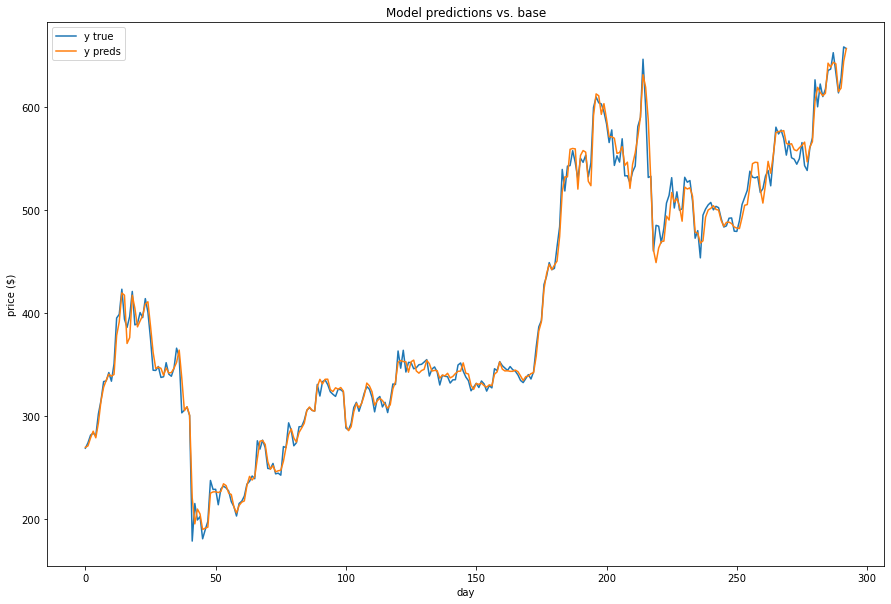

In [63]:
fig, ax = plt.subplots(figsize=(15,10)) # (width, height)
ax.plot(range(0,293), y_test)
ax.plot(range(0,293), y_preds)
ax.set(title="Model predictions vs. base", 
       xlabel="day",
       ylabel="price ($)")
ax.legend(['y true', 'y preds'])

plt.show()

In [35]:
y_preds.shape, y_test.shape

((293,), (293,))

In [36]:
print(y_test.std())
print(y_preds.std())
print()

y_preds_df = pd.DataFrame(y_preds, y_test)
print(y_preds_df)

122.05198338916829
121.70831237717121

                     0
Close                 
269.136780  270.021104
274.385925  271.419333
281.832123  279.191636
283.770416  285.622204
281.152222  279.236095
...                ...
632.921814  642.083279
613.828186  615.049100
628.373657  618.440558
658.429077  644.317676
656.795837  656.843798

[293 rows x 1 columns]


In [55]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe
    fig, ax = plt.subplots(figsize=(15, 12))
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

## RandomizedSearchCV

In [89]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"]}

# Instantiate RandomizedSearchCV model
# NOTE: if we had the time we would boost n_iter to try out far more combinations
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                   random_state=42),
                              param_distributions=rf_grid,
                              n_iter=50,
                              cv=5,
                              verbose=True)

# Fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 12.4 s, sys: 1.18 s, total: 13.6 s
Wall time: 18.6 s


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   18.6s finished


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=50,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [91]:
# Find the best model hyperparameters
rs_model.best_params_

{'n_estimators': 40,
 'min_samples_split': 4,
 'min_samples_leaf': 5,
 'max_features': 'auto',
 'max_depth': None}

In [92]:
# Evaluate the RandomizedSearch model
show_scores(rs_model)

{'Test Accuracy': 0.994047946507378,
 'Training MAE': 5.885336338524008,
 'Test MAE': 6.6268313044298015,
 'Training RMSLE': 0.02449106189473884,
 'Test RMSEL': 0.025198950786041726,
 'Training R^2': 0.9982641729393633,
 'Test R^2': 0.994047946507378}

In [97]:
%%time 

# Train model with the best params
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=4,
                                    min_samples_split=5,
                                    max_features='auto',
                                    max_depth=None,
                                    n_jobs=1,
                                    random_state=42)

ideal_model.fit(X_train, y_train)

CPU times: user 137 ms, sys: 3.6 ms, total: 140 ms
Wall time: 148 ms


RandomForestRegressor(min_samples_leaf=4, min_samples_split=5, n_estimators=40,
                      n_jobs=1, random_state=42)

In [98]:
show_scores(ideal_model)

{'Test Accuracy': 0.9940607227875783,
 'Training MAE': 5.301640960665475,
 'Test MAE': 6.584068251058241,
 'Training RMSLE': 0.021560501092752815,
 'Test RMSEL': 0.024904637571026726,
 'Training R^2': 0.9986017786657584,
 'Test R^2': 0.9940607227875783}